In [1]:
import sys
import os
import logging

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%matplotlib inline

from BDT import (
    read_data,
    read_features,
    prepare_test_data,
    prepare_test_data_matrix,
    prepare_data_matrix,
)
shap.initjs()

In [14]:
# load data and model
SPLIT_FRACTION = 0.5
data = read_data("./input/")
feature_names = read_features(data)
data_test = prepare_test_data(data, SPLIT_FRACTION)
test_data_matrix = prepare_test_data_matrix(data_test, feature_names)

X = data[feature_names]
X_test = data_test[feature_names]


booster = xgb.Booster()
booster.load_model("./output/booster.bin")
booster.feature_names = feature_names # save_model does not save feature names
booster.feature_types = ['float' for x in range(len(feature_names))]

In [3]:
# get predictions
BEST_CUT = 0.18
predictions = booster.predict(test_data_matrix)

true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

for i, prediction in enumerate(predictions):
    if bool(test_data_matrix.get_label()[i]):
        if prediction > BEST_CUT:
            true_positives.append(i)
        else:
            false_negatives.append(i)
    else:
        if prediction < BEST_CUT:
            true_negatives.append(i)
        else:
            false_positives.append(i)
#print(true_positives)
#print(true_negatives)
print(false_positives)
print(false_negatives)

[56, 160, 204, 282, 288, 289, 379, 435, 488, 548, 599, 618, 682, 854, 864, 882, 896, 994, 1027, 1043, 1049, 1142, 1237, 1269, 1304, 1327, 1339, 1340, 1349, 1399, 1401, 1491, 1599, 1649, 1750, 1824, 1939, 2179, 2368, 2390, 2433, 2462, 2500, 2516, 2518, 2543, 2618, 2632, 2726, 2727, 2741, 2769, 2837, 2843, 2893, 2927, 3047, 3058, 3059, 3126, 3128, 3172, 3187, 3209, 3304, 3343, 3368, 3399, 3510, 3527, 3541, 3562, 3648, 3745, 3809, 3841, 3884, 3929, 4042, 4165, 4182]
[0, 52, 350, 374, 519, 781, 826, 842, 892, 1023, 1459, 1529, 1541, 1594, 1628, 1630, 1669, 1784, 1788, 1895, 2029, 2151, 2367, 2391, 2414, 2497, 2578, 2703, 2887, 3052, 3208, 3323, 3438, 3572, 3614, 3638, 3641, 3769, 4010, 4088, 4121, 4130, 4139, 4211]


In [41]:
# calculate shap values
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)
# shap_values = explainer.shap_values(X_test)

In [35]:
# shift indices so that they refer to the whole dataset
shifted_false_positives = list(map(lambda x: x+4235, false_positives))
shifted_false_negatives = list(map(lambda x: x+4235, false_negatives))

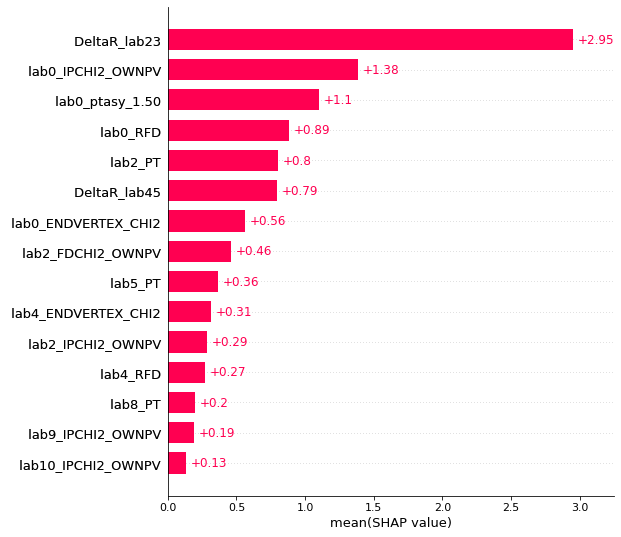

[2.9496393  0.7931042  0.56344116 1.3835684  0.88514704 1.0998027
 0.12983274 0.45974913 0.28795028 0.8013921  0.3138931  0.27071306
 0.36200514 0.19625762 0.1886289 ]


In [42]:
# Global importance plot for reference
shap.plots.bar(explainer(X), max_display=20)
global_importance = np.abs(shap_values).mean(0)

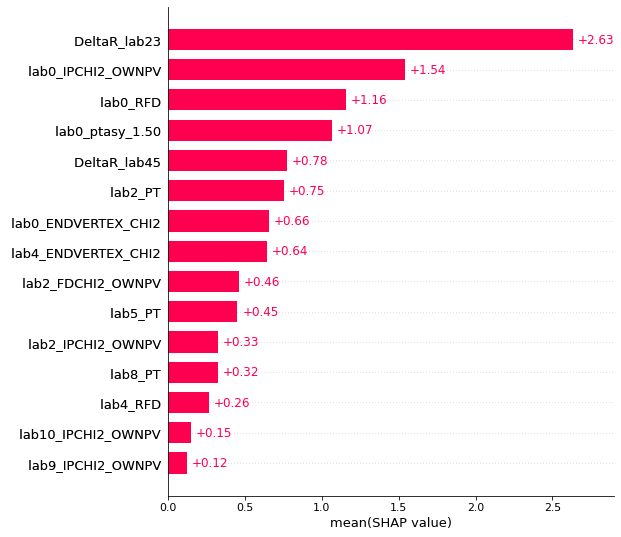

Text(0.5, 0, 'SHAP value difference')

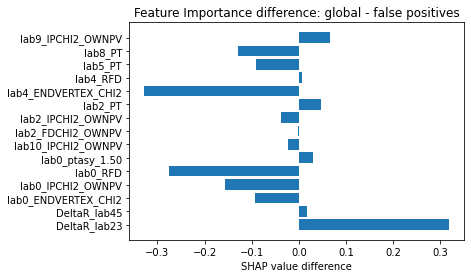

In [50]:
# Global False Positives
# shap.plots.bar(explainer(X_test.iloc[false_positives]), max_display=20)
shap.plots.bar(explainer(X.iloc[shifted_false_positives]), max_display=20)
fp_shap_values = explainer.shap_values(X.iloc[shifted_false_positives])
fp_importance = np.abs(fp_shap_values).mean(0)
fp_diff = np.subtract(global_importance, fp_importance)
plt.barh(feature_names[:], fp_diff)
plt.title("Feature Importance difference: global - false positives")
plt.xlabel("SHAP value difference")

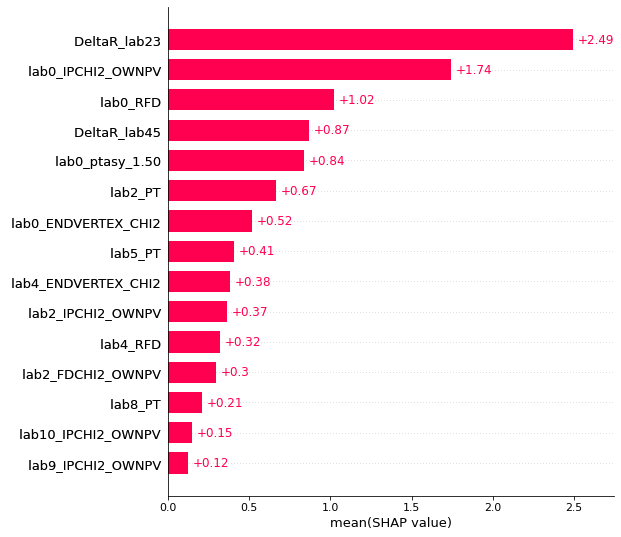

Text(0.5, 0, 'SHAP value difference')

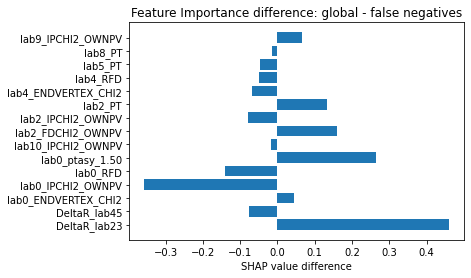

In [51]:
# Global False Negatives
# shap.plots.bar(explainer(X_test.iloc[false_positives]), max_display=20)
shap.plots.bar(explainer(X.iloc[shifted_false_negatives]), max_display=20)
fn_shap_values = explainer.shap_values(X.iloc[shifted_false_negatives]) # how is this calculated?
fn_importance = np.abs(fn_shap_values).mean(0)
fn_diff = np.subtract(global_importance, fn_importance)
plt.barh(feature_names[:], fn_diff)
plt.title("Feature Importance difference: global - false negatives")
plt.xlabel("SHAP value difference")

Text(0.5, 0, 'SHAP value difference')

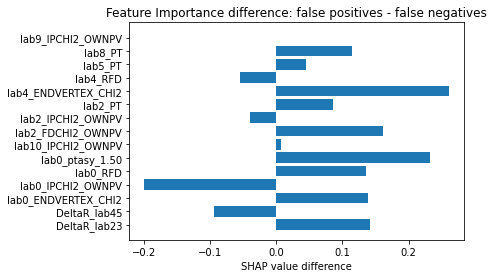

In [53]:
fp_fn_diff = np.subtract(fp_importance, fn_importance)
plt.barh(feature_names[:], fp_fn_diff)
plt.title("Feature Importance difference: false positives - false negatives")
plt.xlabel("SHAP value difference")

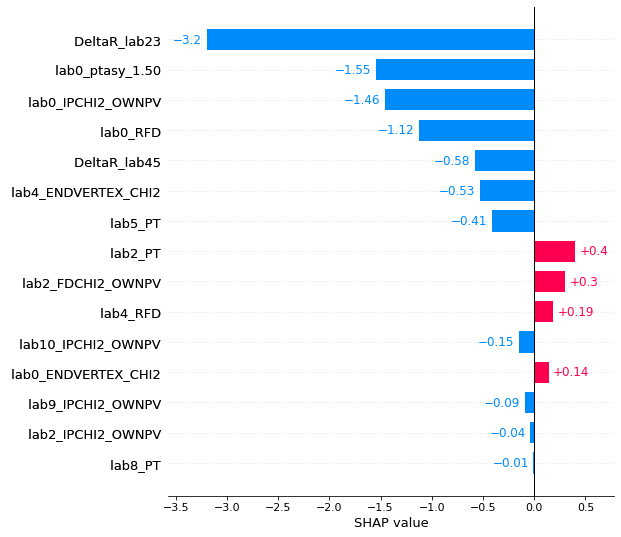

SHAP value:-8.1054229978472
model output: 3.352225758135319e-05
DeltaR_lab23              1.455867
DeltaR_lab45              0.663677
lab0_ENDVERTEX_CHI2       4.114380
lab0_IPCHI2_OWNPV        11.851128
lab0_RFD                  0.298488
lab0_ptasy_1.50          -0.370431
lab10_IPCHI2_OWNPV       95.162132
lab2_FDCHI2_OWNPV      1605.404710
lab2_IPCHI2_OWNPV         1.380823
lab2_PT                2835.772428
lab4_ENDVERTEX_CHI2      14.147675
lab4_RFD                  0.378602
lab5_PT                 236.016476
lab8_PT                 926.077118
lab9_IPCHI2_OWNPV       295.087945
Name: 5863, dtype: float64


In [73]:
# Worst False Negative
worst_false_negative_idx = np.argmin(predictions[false_negatives])
idx = worst_false_negative_idx
shap.plots.bar(explainer(X.iloc[shifted_false_negatives])[idx], max_display=20)
print(f"SHAP value:{sum(explainer.shap_values(X.iloc[shifted_false_negatives])[idx])}")
print(f"model output: {predictions[false_negatives[idx]]}")
print(X.iloc[shifted_false_negatives[idx]])

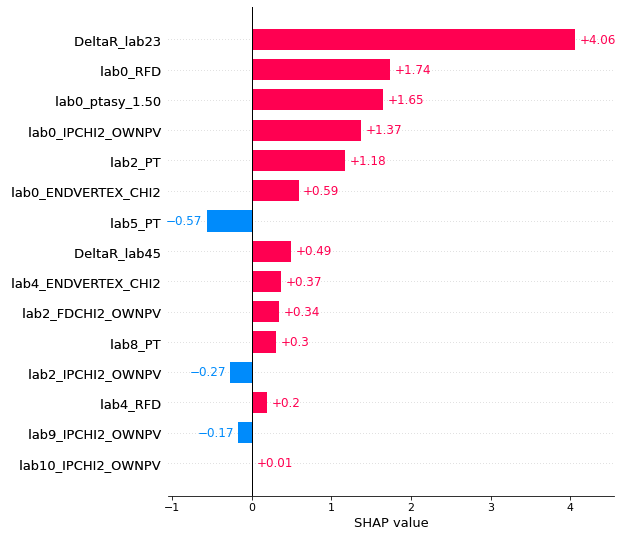

SHAP value:11.306880065239966
model output: 0.9998893737792969
DeltaR_lab23              0.098808
DeltaR_lab45              0.281825
lab0_ENDVERTEX_CHI2       1.470547
lab0_IPCHI2_OWNPV         1.183923
lab0_RFD                  2.322588
lab0_ptasy_1.50           0.543905
lab10_IPCHI2_OWNPV       58.844729
lab2_FDCHI2_OWNPV      1666.522334
lab2_IPCHI2_OWNPV         0.259666
lab2_PT                5168.405774
lab4_ENDVERTEX_CHI2       0.311359
lab4_RFD                  2.652607
lab5_PT                 230.298329
lab8_PT                 904.408212
lab9_IPCHI2_OWNPV       197.411947
Name: 5377, dtype: float64


In [74]:
# Worst False Positive
worst_false_positive_idx = np.argmax(predictions[false_negatives])
idx = worst_false_positive_idx
shap.plots.bar(explainer(X.iloc[shifted_false_positives])[idx], max_display=20)
print(f"SHAP value:{sum(explainer.shap_values(X.iloc[shifted_false_positives])[idx])}")
print(f"model output: {predictions[false_positives[idx]]}")
print(X.iloc[shifted_false_positives[idx]])

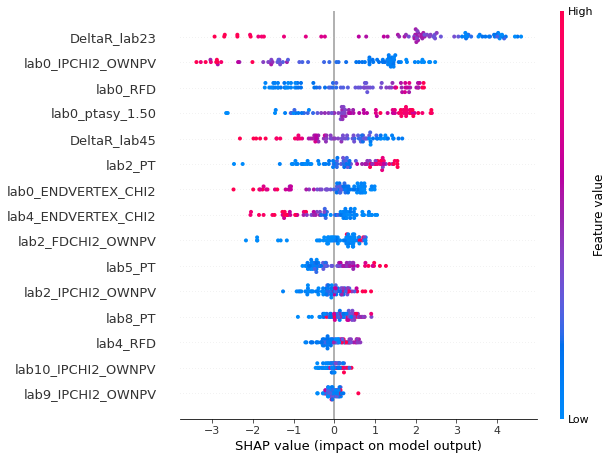

In [8]:
# summarize the effects of false positives
shap.summary_plot(shap_values[false_positives], X_test.iloc[false_positives])

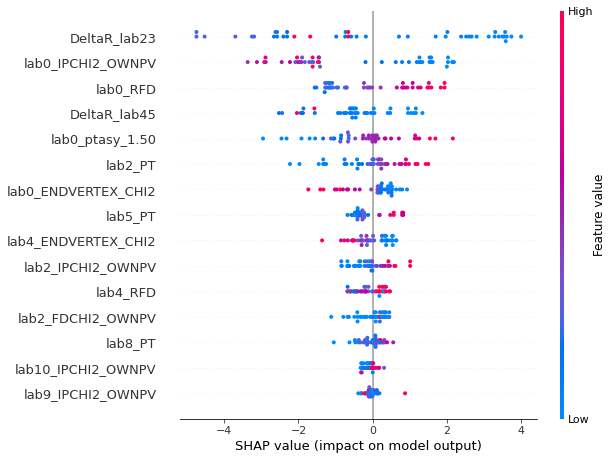

In [9]:
# summarize the effects of false negatives
shap.summary_plot(shap_values[false_negatives], X_test.iloc[false_negatives])

In [10]:
shap.force_plot(explainer.expected_value, shap_values[false_negatives], X_test.iloc[false_negatives])

In [11]:
shap.force_plot(explainer.expected_value, shap_values[false_positives], X_test.iloc[false_positives])

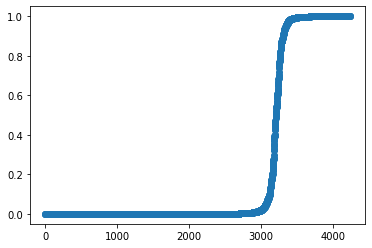

In [12]:
# plt.scatter(X_test.iloc[false_positives]["DeltaR_lab23"], shap_values[false_positives][:,0])
plt.scatter(range(len(predictions)), sorted(predictions))